<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D3_OptimalControl/W3D3_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Optimal Control for Continuous State
**Week 3, Day 3: Optimal Control**

**By Neuromatch Academy**

__Content creators:__ Zhengwei Wu, Shreya Saxena, Xaq Pitkow

__Content reviewers:__ Karolina Stosio, Roozbeh Farhoodi, Saeed Salehi, Ella Batty, Spiros Chavlis, Matt Krause and Michael Waskom


**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives
In this tutorial, we will implement a continuous control task: you will design control inputs for a linear dynamical system to reach a target state. The state here is continuous-valued, i.e. takes on any real number from $-\infty$ to $\infty$.

You have already learned about control for binary states in Tutorial 1, and you have learned about stochastic dynamics, latent states, and measurements yesterday. Now we introduce you to the new concepts of designing a controller with full observation of the state (linear qudratic regulator - LQR), and under partial observability of the state (linear quadratic gaussian - LQG).

The running example we consider throughout the tutorial is a cat trying to catch a mouse in space, using its handy little jet pack to navigate. 

In [ ]:
# @title Tutorial slides

# @markdown These are the slides for all videos in this tutorial.
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/8j5rs/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [1]:
# Imports

import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import isclose

In [2]:
#@title Figure Settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_vs_time(s, slabel, color, goal=None, ylabel=None):
  plt.plot(s, color, label=slabel)
  if goal is not None:
    plt.plot(goal, 'm', label='goal $g$')
  plt.xlabel("Time", fontsize=14)
  plt.legend(loc="upper right")

  if ylabel:
    plt.ylabel(ylabel, fontsize=14)

In [4]:
# @title Helper Functions

class ExerciseError(AssertionError):
  pass


def test_lds_class(lds_class):
  from math import isclose
  ldsys = lds_class(T=2, ini_state=2., noise_var=0.)
  if not isclose(ldsys.dynamics(.9)[1], 1.8):
      raise ExerciseError("'dynamics' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_openloop(.9, 2., np.zeros(ldsys.T)-1.)[1], -0.2):
      raise ExerciseError("'dynamics_openloop' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[0][1], 3.):
      raise ExerciseError("s[t] in 'dynamics_closedloop' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[1][0], .6):
      raise ExerciseError("a[t] in 'dynamics_closedloop' method is not correctly implemented!")
  ldsys.noise_var = 1.
  if isclose(ldsys.dynamics(.9)[1], 1.8):
      raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics'?")
  if isclose(ldsys.dynamics_openloop(.9, 2., np.zeros(ldsys.T)-1.)[1], -0.2):
      raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics_openloop'?")
  if isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[0][1], 3.):
      raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics_closedloop'?")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[1][0], .6):
      raise ExerciseError("Your input a[t] should not be noisy in 'dynamics_closedloop'.")

  print('Well Done!')


def test_lqr_class(lqr_class):
  from math import isclose
  lqreg = lqr_class(T=2, ini_state=2., noise_var=0.)
  lqreg.goal = np.array([-2, -2])
  s = np.array([1, 2])
  a = np.array([3, 4])
  if not isclose(lqreg.calculate_J_state(s), 25):
      raise ExerciseError("'calculate_J_state' method is not correctly implemented!")
  if not isclose(lqreg.calculate_J_control(a), 25):
      raise ExerciseError("'calculate_J_control' method is not correctly implemented!")

  print('Well Done!')

---
# Section 1: Exploring a Linear Dynamical System (LDS) with Open-Loop and Closed-Loop Control

In [5]:
# @title Video 1: Flying Through Space
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Zv411B7WV", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="MLUTR8z16jI", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


In this example, a cat is trying to catch a mouse in space. The location of the mouse is the goal state $g$, here a static goal. Later on, we will make the goal time varying, i.e. $g(t)$. The cat's location is the state of the system $s_t$. The state has its internal dynamics: think of the cat drifting slowly in space. These dynamics are such that the state at the next time step $s_{t+1}$ are a linear function of the current state $s_t$. There is some environmental noise (think: meteorites) affecting the state, here modeled as gaussian noise $w_t$.

The control input or action $a_t$ is the action of the jet pack, which has an effect $Ba_t$ on the state at the next time step $s_{t+1}$. In this tutorial, we will be designing the action $a_t$ to reach the goal $g$, with known state dynamics.

Thus, our linear discrete-time system evolves according to the following equation:

\begin{eqnarray*}
s_{t+1} &=& Ds_t + Ba_t + w_t \tag{1}\\
s_{0} &=& s_{init}
\end{eqnarray*}

with 

$t$: time step, ranging from $1$ to $T$, where $T$ is the time horizon.

$s_t$: state at time $t$ 

$a_t$: action at time $t$ (also known as control input)

$w_t$: gaussian noise at time $t$

$D$ and $B$: parameters of the linear dynamical system. 

For simplicity, we will consider the 1D case, where the matrices reduce to scalars, and the states, control and noise are one-dimensional as well. Specifically, $D$ and $B$ are scalars.

We will consider the goal $g$ to be the origin, i.e. $g=0$, for Exercises 1 and 2.2. Note that if the state dynamics are stable, the state reaches $0$ in any case. This is a slightly unrealistic situation for the purposes of simplicity, but we will see more realistic cases later on with $g \neq 0$

**Stability** \\
The system is stable, i.e. the output remains finite for any finite initial condition $s_{init}$, if $|D|<1$.

**Control** \\
In *open-loop control*, $a_t$ is not a function of $s_t$. In *closed-loop linear control*, $a_t$ is a linear function of the state $s_t$. Specifically, $a_t$ is the control gain $L_t$ multiplied by $s_t$, i.e. $a_t=L_t s_t$. For now, you will explore these equations, and later on, you will *design* $L_t$ to reach the goal $g$.

### Coding Exercise 1: Implement state evolution equations


Implement the state evolution equations in the class methods as provided below, for the following cases:

(a) no control: `def dynamics`

(b) open-loop control: `def dynamics_openloop`

(c) closed-loop control: `def dynamics_closedloop`

*Tip: refer to Equation (1) above. The provided code uses the same notation*

In [6]:
class LDS:
  def __init__(self, T: int, ini_state: float, noise_var: float):
    self.T = T  # time horizon
    self.ini_state = ini_state
    self.noise_var = noise_var

  def dynamics(self, D: float):
    s = np.zeros(self.T)  # states initialization
    s[0] = self.ini_state
    noise = np.random.normal(0, self.noise_var, self.T)

    for t in range(self.T - 1):
      ####################################################################
      ## Insert your code here to fill with the state dynamics equation
      ## without any control input
      ## complete the function and remove
      #raise NotImplementedError("Exercise: Please complete 'dynamics'")
      ####################################################################
      # calculate the state of t+1
      s[t + 1] = D * s[t] + noise[t]

    return s

  def dynamics_openloop(self, D: float, B: float, a: np.ndarray):

    s = np.zeros(self.T)  # states initialization
    s[0] = self.ini_state
    noise = np.random.normal(0, self.noise_var, self.T)

    for t in range(self.T - 1):
      ####################################################################
      ## Insert your code here to fill with the state dynamics equation
      ## with open-loop control input a[t]
      ## complete the function and remove
      #raise NotImplementedError("Please complete 'dynamics_openloop'")
      ####################################################################
      # calculate the state of t+1
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s

  def dynamics_closedloop(self, D: float, B: float, L: np.ndarray):

    s = np.zeros(self.T)  # states initialization
    s[0] = self.ini_state
    noise = np.random.normal(0, self.noise_var, self.T)
    a = np.zeros(self.T - 1)

    for t in range(self.T - 1):
      ####################################################################
      ## Insert your code here to fill with the state dynamics equation
      ## with closed-loop control input as a function of control gain L.
      ## complete the function and remove
      #raise NotImplementedError("Please complete 'dynamics_closedloop'")
      ####################################################################
      # calculate the current action
      a[t] = L[t] * s[t]
      # calculate the next state
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s, a


# Test your function
test_lds_class(LDS)

Well Done!


In [7]:
# to_remove solution
class LDS:
  def __init__(self, T: int, ini_state: float, noise_var: float):
    self.T = T  # time horizon
    self.ini_state = ini_state
    self.noise_var = noise_var

  def dynamics(self, D: float):
    s = np.zeros(self.T)  # states initialization
    s[0] = self.ini_state
    noise = np.random.normal(0, self.noise_var, self.T)

    for t in range(self.T - 1):
      # calculate the state of t+1
      s[t + 1] = D * s[t] + noise[t]

    return s

  def dynamics_openloop(self, D: float, B: float, a: np.ndarray):

    s = np.zeros(self.T)  # states initialization
    s[0] = self.ini_state
    noise = np.random.normal(0, self.noise_var, self.T)

    for t in range(self.T - 1):
      # calculate the state of t+1
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s

  def dynamics_closedloop(self, D: float, B: float, L: np.ndarray):

    s = np.zeros(self.T)  # states initialization
    s[0] = self.ini_state
    noise = np.random.normal(0, self.noise_var, self.T)
    a = np.zeros(self.T - 1)

    for t in range(self.T - 1):
      # calculate the current action
      a[t] = L[t] * s[t]
      # calculate the next state
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s, a


# Test your function
test_lds_class(LDS)

Well Done!


### Interactive Demo 1.1: Explore no control vs. open-loop control vs. closed-loop control

Once your code above passes the tests, use the interactive demo below to visualize the effects of different kinds of control inputs. 

(a) For the no-control case, can you identify two distinct outcomes, depending on the value of D? Why? 

(b) The open-loop controller works well--or does it? Run the simulation multiple times and see if there are any problems, especially in challenging (high noise) conditions. 

(c) Does the closed-loop controller fare better with the noise? Vary the values of $L$ and find a range where it quickly reaches the goal. 


In [8]:
#@markdown Make sure you execute this cell to enable the widget!

#@markdown Play around (attentively) with **`a`** and **`L`** to see the effect on the open-loop controlled and closed-loop controlled state.

def simulate_lds(D=0.95, L=-0.3, a=-1., B=2., noise_var=0.1,
                 T=50, ini_state=2.):

    # linear dynamical system
    lds = LDS(T, ini_state, noise_var)

    # No control
    s_no_control=lds.dynamics(D)

    # Open loop control
    at = np.append(a, np.zeros(T - 1))
    s_open_loop = lds.dynamics_openloop(D, B, at)

    # Closed loop control
    Lt =  np.zeros(T) + L
    s_closed_loop, a_closed_loop = lds.dynamics_closedloop(D, B, Lt)

    plt.figure(figsize=(10, 6))
    plt.plot(s_no_control, 'b', label='No control')
    plt.plot(s_open_loop, 'g', label='Open Loop with a = {}'.format(a))
    plt.plot(s_closed_loop, 'r', label='Closed Loop with L = {}'.format(L))
    plt.plot(np.zeros(T), 'm', label='goal')
    plt.title('LDS State Evolution')
    plt.ylabel('State', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.legend(loc="upper right")
    plt.show()

widget=interactive(simulate_lds, {'manual': True},
                   D=(.85, 1.05, .1),
                   L=(-0.6, 0., .15),
                   a=(-2., 1., 1.),
                   B=(1., 3., 1.),
                   noise_var=(0., 0.2, .1),
                   T=fixed(50),
                   ini_state=(2., 10., 4.))

widget.children[-2].description='Run Simulation'
widget.children[-2].style.button_color='lightgreen'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

In [ ]:
# to_remove explanation

"""
In Exercise 1.2, you should have noticed the following:

* No control (blue): the dynamics parameter D controls how fast the dynamics decay
  towards 0. For -1<D<1, the system is stable and therefore approaches zero quickly.
  However, D>1 produces an unstable system, causing , you should have
  noticed that the 'no control' state (blue curve) rapidly explodes
  (i.e., heads off to infinity)

* Open-loop control: While the open-loop state (green curve) often reachs the goal
  quickly, it may not stay there. Under high noise conditions, it tends to
  drift away from the goal, though you may not see this in every simulation.

* Closed-loop control: The closed-loop state (red curve) reaches the goal and
  stays there even in the presence of noise. It converges especially quickly for
  Ls around 0.45

  Remember that in closed-loop control,
  we have a[t]=L[t] * s[t] $. Note that with a constant control gain $L[t]=L,
  the state evolution equations can be rearranged to show that the stability of
  the closed-loop system now depends on the value of D+BL. (See Equation 2, below).

  If $|D+BL|<1$, our closed-loop system will be stable. More generally, you can
  view the role of a closed-loop control input as changing the system *dynamics*
  in an optimal way to reach the goal.
""";

### Interactive Demo 1.2: Exploring the closed-loop setting further 
Execute the cell below to visualize the MSE between the state and goal, as a function of control gain $L$. You should see a U-shaped curve, with a clear minimum MSE. The control gain at which the minimum MSE is reached, is the 'optimal' constant control gain for minimizing MSE, here called the numerical optimum. 

A green dashed line is shown $L = -\frac{D}{B}$ with $D=0.95$ and $B=2$. Consider how Why is this the theoretical optimal control gain for minimizing MSE of the state $s$ to the goal $g=0$? Examine how the states evolve with a constant gain $L$
$$
\begin{eqnarray*}
s_{t+1} &=& Ds_t + Ba_t + w_t \\
&=& Ds_t + B(Ls_t) + w_t \\
&=& (D+BL)s_t + w_t \tag{2}
\end{eqnarray*}
$$

Now, let's visualize the evolution of the system as we change the control gain. We will start with the optimal gain (the control gain that gets us the minimum MSE), and then explore over- and under- ambitious values. 

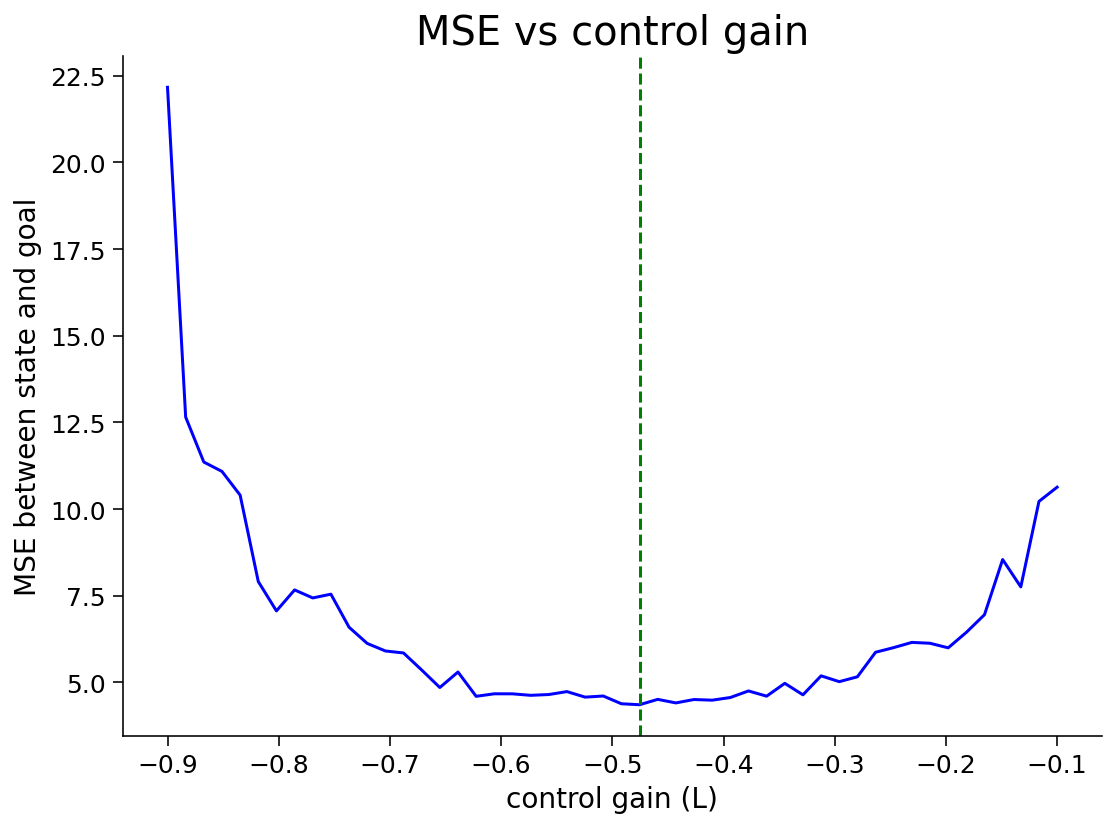

In [9]:
#@markdown Execute this cell to visualize MSE between state and goal, as a function of control gain
def calculate_plot_mse():
  D, B, noise_var, T, ini_state = 0.95, 2., 0.1, 50, 2.
  control_gain_array = np.linspace(0.1, 0.9, T)
  mse_array = np.zeros(control_gain_array.shape)
  for i in range(len(control_gain_array)):
    lds = LDS(T, ini_state, noise_var)
    L = - np.ones(T) * control_gain_array[i]
    s, a = lds.dynamics_closedloop(D, B, L)
    mse_array[i] = np.sum(s**2)

  plt.figure()
  plt.plot(-control_gain_array, mse_array, 'b')
  plt.axvline(x=-D/B, color='g', linestyle='--')
  plt.xlabel("control gain (L)", fontsize=14)
  plt.ylabel("MSE between state and goal" , fontsize=14)
  plt.title("MSE vs control gain", fontsize=20)
  plt.show()


calculate_plot_mse()

In [10]:
#@markdown Make sure you execute this cell to enable the widget!

#@markdown Explore different values of control gain **`L`** (close to optimal, over- and under- ambitious) \\


def simulate_L(L:float=-0.45):
  D, B, noise_var, T, ini_state = 0.95, 2., 0.1, 50, 2.
  lds = LDS(T, ini_state, noise_var)
  # Closed loop control with the numerical optimal control gain
  Lt = np.ones(T) * L
  s_closed_loop_choice, _ = lds.dynamics_closedloop(D, B, Lt)
  # Closed loop control with the theoretical optimal control gain
  L_theory = - D / B * np.ones(T)
  s_closed_loop_theoretical, _ = lds.dynamics_closedloop(D, B, L_theory)
  # Plotting closed loop state evolution with both theoretical and numerical optimal control gains
  plt.figure(figsize=(10, 6))
  plot_vs_time(s_closed_loop_theoretical,
                'Closed Loop (Theoretical optimal control gain)','b')
  plot_vs_time(s_closed_loop_choice,
                'Closed Loop (your choice of L = {})'.format(L), 'g',
                goal=np.zeros(T), ylabel="State")
  plt.title('Closed Loop State Evolution')
  plt.show()


widget=interactive(simulate_L, {'manual': True}, L=(-1.05, 0.051, .1))

widget.children[-2].description='Run Simulation'
widget.children[-2].style.button_color='lightgreen'

controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

In [ ]:
#to_remove explanation
"""
In Demo 1.2, you should have seen that the optimal control gain (L = -0.45) takes a
short amount of time to get to the goal, and then stays there. We can try to get
to the goal in an even shorter time using an 'over-ambitious' control gain (L < -0.45), but
this may actually overshoot the goal and may cause oscillations in the system,
thus increasing the MSE. On the other hand, an 'under-ambitious' control gain
takes a longer time to get to the goal and thus increases the MSE.
Finally, at L>0, the system runs away to infinity.

Why is L=-D/B optimal for reaching our goal? Recall that our next state is
(D+B*L)*s[t] + noise. Plugging that L=-D/B causes that leading term to become zero,
which is our goal. Since the noise has zero mean, it's not possible to do any better!

""";

---
# Section 2: Designing an optimal control input using a linear quadratic regulator (LQR)

In [11]:
# @title Video 2: Linear quadratic regulator (LQR)
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1sz411v7za", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="NZSwDy7wtIs", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 2.1 Constraints on the system
Now we will start imposing additional constraints on our system. For example. 
if you explored different values for $s_{init}$ above, you would have seen very large values for $a_t$ in order to get to the mouse in a short amount of time. However, perhaps the design of our jetpack makes it dangerous to use large amounts of fuel in a single timestep. We certainly do not want to explode, so we would like to keep the actions $a_t$ as small as possible while still mantaining good control.

Moreover, in Exercise 1, we had restricted ourselves to a static control gain $L_t \equiv L$. How would we vary it if we could?

This leads us to a more principled way of designing the optimal control input.
### Setting up a cost function 

In a finite-horizon LQR problem,  the cost function is defined as: 

\begin{eqnarray}
J({\bf s},{\bf a}) &=& J_{state}({\bf s}) + \rho J_{control}({\bf a}) \\
 &=& \sum_{t = 0}^{T} (s_{t}-g)^2 + \rho \sum_{t=0}^{T-1}a_{t}^2 \tag{3}
\end{eqnarray}

where $\rho$ is the weight on the control effort cost, as compared to the cost of not being at the goal. Here, ${\bf a} = \{a_t\}_{t=0}^{T-1}$, ${\bf s} = \{s_t\}_{t=0}^{T}$. This is a quadratic cost function. In Exercise $2$, we will only explore $g=0$, in which case $J_{state}({\bf s})$ can also be expressed as $\sum_{t = 0}^{T} s_{t}^2$. In Exercise $3$, we will explore a non-zero time-varying goal.

The goal of the LQR problem is to find control ${\bf a}$ such that $J({\bf s},{\bf a})$ is minimized. The goal is then to find the control gain at each time point, i.e.,

$$ \text{argmin} _{\{L_t\}_{t=0}^{T-1}}  J({\bf s},{\bf a}) \tag{4} $$ 

where $a_t = L_t s_t$.


## Section 2.2 Solving LQR
The solution to Equation (4), i.e. LQR for a finite time horizon, can be obtained via Dynamic Programming. For details, check out [this lecture by Stephen Boyd](https://stanford.edu/class/ee363/lectures/dlqr.pdf).

For an infinite time horizon, one can obtain a closed-form solution using Riccati equations, and the solution for the control gain becomes time-invariant, i.e. $L_t \equiv L$. We will use this in Exercise 4. For  details, check out [this other lecture by Stephen Boyd](https://stanford.edu/class/ee363/lectures/dlqr-ss.pdf).

Additional reference for entire section: \\
[Bertsekas, Dimitri P. "Dynamic programming and optimal control". Vol. 1. No. 2. Belmont, MA: Athena scientific, 1995.](http://www.athenasc.com/dpbook.html)


### Coding Exercise 2.2: Implement the cost function
The cost function $J_{control}({\bf s}, {\bf a})$ can be divided into two parts: $J_{state}({\bf s})$ and $J_{control}({\bf a})$. 

Code up these two parts in the class methods `def calculate_J_state` and `def calculate_J_control` in the following helper class for LQR. 


In [15]:
class LQR(LDS):
  def __init__(self, T, ini_state, noise_var):
    super().__init__(T, ini_state, noise_var)
    self.goal = np.zeros(T)  # The class LQR only supports g=0

  def control_gain_LQR(self, D, B, rho):
    P = np.zeros(self.T)  # Dynamic programming variable
    L = np.zeros(self.T - 1)  # control gain
    P[-1] = 1

    for t in range(self.T - 1):
        P_t_1 = P[self.T - t - 1]
        P[self.T - t-2] = (1 + P_t_1 * D**2 - D * P_t_1 * B / (
                rho + P_t_1 * B) * B**2 * P_t_1 * D)

        L[self.T - t-2] = - (1 / (rho + P_t_1 * B**2) * B * P_t_1 * D)
    return L

  def calculate_J_state(self, s:np.ndarray):
    ########################################################################
    ## Insert your code here to calculate J_state(s) (see Eq. 3)
    ## complete the function and remove
    #raise NotImplementedError("Please complete 'calculate_J_state'")
    ########################################################################
    # calculate the state
    J_state = np.sum( (s - self.goal)**2 )

    return J_state

  def calculate_J_control(self, a:np.ndarray):
    ########################################################################
    ## Insert your code here to calculate J_control(a) (see Eq. 3).
    ## complete the function and remove
    #raise NotImplementedError("Please complete 'calculate_J_control'")
    ########################################################################
    # calculate the control
    J_control = np.sum(a ** 2)

    return J_control


# Test class
test_lqr_class(LQR)

Well Done!


In [16]:
# to_remove solution
class LQR(LDS):
  def __init__(self, T, ini_state, noise_var):
    super().__init__(T, ini_state, noise_var)
    self.goal = np.zeros(T)  # The class LQR only supports g=0

  def control_gain_LQR(self, D, B, rho):
    P = np.zeros(self.T)  # Dynamic programming variable
    L = np.zeros(self.T - 1)  # control gain
    P[-1] = 1

    for t in range(self.T - 1):
        P_t_1 = P[self.T - t - 1]
        P[self.T - t-2] = (1 + P_t_1 * D**2 - D * P_t_1 * B / (
                rho + P_t_1 * B) * B**2 * P_t_1 * D)

        L[self.T - t-2] = - (1 / (rho + P_t_1 * B**2) * B * P_t_1 * D)
    return L

  def calculate_J_state(self, s:np.ndarray):
    # calculate the state
    J_state = np.sum((s - self.goal)**2)

    return J_state

  def calculate_J_control(self, a:np.ndarray):
    # calculate the control
    J_control = np.sum(a**2)

    return J_control

# Test class
test_lqr_class(LQR)

Well Done!


### Interactive Demo 2.2: LQR to the origin 

In this exercise, we will use your new LQR controller to track a static goal at $g=0$. Here, we will explore how varying $\rho$ affects its actions by\\

1.   Using Equation 3, find a value for $\rho$ that will get you the same cost and control gain as Exercise 1.
2.   Pick a larger value for $\rho$ and see the effect on the action.
3.   Try increasing the rho to 2. What do you notice? \\
4.   For different values of $\rho$, how does the control gain vary? 

In [18]:
#@markdown Make sure you execute this cell to enable the widget!

def simulate_rho(rho=1.):
    D, B, T, ini_state, noise_var = 0.9, 2., 50, 2., .1  # state parameter
    lqr = LQR(T, ini_state, noise_var)
    L = lqr.control_gain_LQR(D, B, rho)
    s_lqr, a_lqr = lqr.dynamics_closedloop(D, B, L)

    plt.figure(figsize=(14, 4))
    plt.suptitle('LQR Control for rho = {}'.format(rho), y=1.05)

    plt.subplot(1, 3, 1)
    plot_vs_time(s_lqr,'State evolution','b',goal=np.zeros(T))
    plt.ylabel('State $s_t$')

    plt.subplot(1, 3, 2)
    plot_vs_time(a_lqr,'LQR Action','b')
    plt.ylabel('Action $a_t$')

    plt.subplot(1, 3, 3)
    plot_vs_time(L,'Control Gain','b')
    plt.ylabel('Control Gain $L_t$')

    plt.tight_layout()
    plt.show()

widget=interactive(simulate_rho, {'manual': True}, rho=(0., 2., 0.5))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'

controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

In [ ]:
# to_remove explanation
"""
* rho=0 will get you the same cost and control gain as in Exercise 1 by
  zeroing out the cost term.
* A small value for rho will have a similar solution as in (a), but with
   potentially large values for |a[t]|.
* A large value for rho, like 2 will lead to small values for |a[t]|.
* The control gain becomes more time-varying (as opposed to fairly static)
  for large rho. For some parameter values, L[t] oscillates during the entire
  trajectory in order to keep $|a_t|$ low. Try D = 0.9, B = 2 and rho = 2.
""";

## Section 2.3: The tradeoff between state cost and control cost

In Exercise 2.1, you implemented code to calculate for $J_{state}$ and $J_{control}$ in the class methods for the class LQR. 

We will now plot them against each other for varying values of $\rho$ to explore the tradeoff between state cost and control cost.

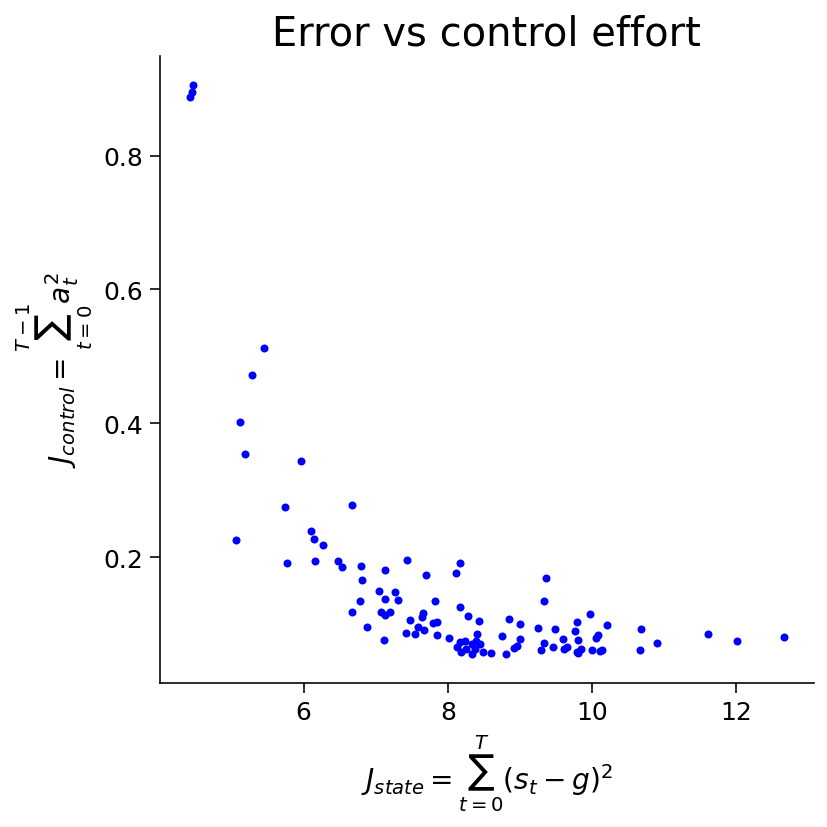

In [19]:
#@markdown Execute this cell to visualize the tradeoff between state and control cost
def calculate_plot_costs():
  D, B, noise_var, T, ini_state = 0.9, 2., 0.1, 50, 2.
  rho_array = np.linspace(0.2, 40, 100)
  J_state = np.zeros(rho_array.shape)
  J_control = np.zeros(rho_array.shape)
  for i in np.arange(len(rho_array)):
    lqr = LQR(T, ini_state, noise_var)
    L = lqr.control_gain_LQR(D, B, rho_array[i])
    s_lqr, a_lqr = lqr.dynamics_closedloop(D, B, L)
    J_state[i] = lqr.calculate_J_state(s_lqr)
    J_control[i] = lqr.calculate_J_control(a_lqr)

  fig = plt.figure(figsize=(6, 6))
  plt.plot(J_state, J_control, '.b')
  plt.xlabel("$J_{state} = \sum_{t = 0}^{T} (s_{t}-g)^2$", fontsize=14)
  plt.ylabel("$J_{control} = \sum_{t=0}^{T-1}a_{t}^2$" , fontsize=14)
  plt.title("Error vs control effort", fontsize=20)
  plt.show()


calculate_plot_costs()

You should notice the bottom half of a 'C' shaped curve, forming the tradeoff between the state cost and the control cost under optimal linear control.
For a desired value of the state cost, we cannot reach a lower control cost than the curve in the above plot. Similarly, for a desired value of the control cost, we must accept that amount of state cost. For example, if you know that you have a limited amount of fuel, which determines your maximum control cost to be $J_{control}^{max}$. 

You will be able to show that you will not be able to track your state with a higher accuracy than the corresponding $J_{state}$ as given by the graph above. This is thus an important curve when designing a system and exploring its control.


---
# Section 3: LQR for tracking a time-varying goal

In [20]:
# @title Video 3: Tracking a moving goal
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1up4y1S7gg", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="HOoqM7kBWSY", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In a more realistic situation, the mouse would move around constantly. Suppose you were able to predict the movement of the mouse as it bounces from one place to another. This becomes your goal trajectory $g_t$.

When the target state, denoted as $g_t$, is not $0$, the cost function becomes
$$ J({\bf a}) = \sum_{t = 0}^{T} (s_{t}- g_t) ^2 + \rho \sum_{t=0}^{T-1}(a_{t}-\bar a_t)^2$$
Here, $\bar a_t$ is the desired action based on the goal trajectory. In other words, the controller considers the goal for the next time step, and designs a preliminary control action that gets the state at the next time step to the desired goal. Specifically, without taking into account noise $w_t$, we would like to design $\bar a_t$ such that $s_{t+1}=g_{t+1}$. Thus, from Equation $(1)$,

\begin{eqnarray*}
g_{t+1} &=& Ds_t + B \bar a_t\\
\bar a_{t} &=& \frac{- Ds_t + g_{t+1}}{B}\\
\end{eqnarray*}

The final control action $a_t$ is produced by adding this desired action $\bar a_t$ with the term with the control gain $L_t(s_t - g_t)$.

In [23]:
#@markdown Execute this cell to include class
#@markdown for LQR control to desired time-varying goal

class LQR_tracking(LQR):
  def __init__(self, T, ini_state, noise_var, goal):
    super().__init__(T, ini_state, noise_var)
    self.goal = goal

  def dynamics_tracking(self, D, B, L):

    s = np.zeros(self.T) # states intialization
    s[0] = self.ini_state

    noise = np.random.normal(0, self.noise_var, self.T)

    a = np.zeros(self.T) # control intialization
    a_bar = np.zeros(self.T)
    for t in range(self.T - 1):
        a_bar[t] = ( - D * s[t] + self.goal[t + 1]) / B
        a[t] =  L[t] * (s[t] - self.goal[t]) + a_bar[t]
        s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s, a, a_bar

  def calculate_J_state(self,s):
    J_state = np.sum((s-self.g)**2)
    return J_state

  def calculate_J_control(self, a, a_bar):
    J_control = np.sum((a-a_bar)**2)
    return J_control

### Interactive Demo 3: LQR control to desired time-varying goal
Use the demo below to explore how LQR tracks a time-varying goal. 
Starting with the sinusoidal goal function `sin`, investigate how the system reacts with different values of $\rho$ and process noise variance. Next, explore other time-varying goal, such as a step function and ramp.

In [24]:
#@markdown Make sure you execute this cell to enable the widget!

def simulate_tracking(rho=20., noise_var=0.1, goal_func='sin'):
  D, B, T, ini_state = 0.9, 2., 100, 0.
  if goal_func == 'sin':
      goal = np.sin(np.arange(T) * 2 * np.pi * 5 / T)
  elif goal_func == 'step':
      goal = np.zeros(T)
      goal[int(T / 3):] = 1.
  elif goal_func == 'ramp':
      goal = np.zeros(T)
      goal[int(T / 3):] = np.arange(T - int(T / 3)) / (T - int(T / 3))

  lqr_time = LQR_tracking(T, ini_state, noise_var, goal)
  L = lqr_time.control_gain_LQR(D, B, rho)
  s_lqr_time, a_lqr_time, a_bar_lqr_time = lqr_time.dynamics_tracking(D, B, L)

  plt.figure(figsize=(13, 5))
  plt.suptitle('LQR Control for time-varying goal', y=1.05)
  plt.subplot(1, 2, 1)
  plot_vs_time(s_lqr_time,'State evolution $s_t$','b',goal, ylabel="State")
  plt.subplot(1, 2, 2)
  plot_vs_time(a_lqr_time, 'Action $a_t$', 'b', ylabel="Action")
  plt.show()


widget=interactive(simulate_tracking, {'manual': True},
                   rho=(0., 40., 10.),
                   noise_var=(0., 1., .2),
                   goal_func=['sin', 'step', 'ramp']
                   )
widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'

controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

In [ ]:
# to_remove explanation

"""
In Exercise 3, you should have noticed that:
* The system follows time varying goals rather well, with little change to the
   cost function and the control equations.

* Setting rho=0 leads to noise in the first part of the time series.
  Here, we see that the control cost in fact acts as a regularizer.

* Larger values of the process noise variance lead to a higher MSE between the
  state and the desired goal.
""";

---
# Section 4: Control of an partially observed state using a Linear Quadratic Gaussian (LQG) controller


## Section 4.1 Introducing the LQG Controller

In [25]:
# @title Video 4: Linear Quadratic Gaussian (LQG) Control
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1xZ4y1u73B", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="c_D7iDLT_bw", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In practice, the controller does not have full access to the state. For example, your jet pack in space may be controlled by Mission Control back on earth!  In this case, noisy measurements $m_t$ of the state $s_t$ are taken via radar, and the controller needs to (1) estimate the true state, and (2) design an action based on this estimate. 

Fortunately, the separation principle tells us that it is optimal to do (1) and (2) separately. This makes our problem much easier, since we already know how to do each step.  

1) *State Estimation*  
Can we recover the state from the measurement? 
From yesterday's lecture, it is known that the states $\hat{s}_t$ can be estimated from the measurements $m_t$ using the __Kalman filter__. 

2) *Design Action*  
In Sections 2 and 3 above, we just learnt about the LQR controller which designs an action based on the state. The separation principle tells us that it is sufficient to replace the use of the state in LQR with the *estimated* state, i.e.

$$a_t = L_t \hat s_t$$

The state dynamics will then be:
$$s_{t+1} = D s_t + B a_t + w_t$$
where $w_t$ is the process noise (proc_noise), and the observation / measurement is:
$$ y_t = C s_t + v_t$$ 
with $v_t$ being the measurement noise (meas_noise).

The combination of (1) state estimation and (2) action design using LQR is known as a **linear quadratic gaussian (LQG)**. Yesterday, you completed the code for Kalman filter.  Based on that, you will code up the LQG controller. For these exercises, we will resturn to using the goal $g=0$, as in Section 2.


### Interactive Demo 4.1: The Kalman filter in conjunction with a linear closed-loop controller (LQG Control)
In the `MyKalmanFilter` class, the method `filter_control` implements filtering in closed-loop feedback. It is a combination of generating samples (states $s_t$) and filtering (generating state estimates $\hat s_t$), as you have seen in yesterday's tutorial. The only difference from yesterday is that today's Kalman filter is in closed loop with the controller. Thus, each $s_{t+1}$ gets an input $a_t$, which itself depends on the state estimate of the last time step $\hat s_t$.

Below you find the code snipets for the Kalman filter in closed loop (`MyKalmanFilter`) class that provide you an insight in action update (`control_policy_LQG`) and state estimation (`state_dynamics_LQG`). Please feel free to inspect the helper functions and classes for the details.


You should have seen the next cell containing `MyKalmanFilter` class yesterday, with the exception of the controller acting on the state estimate in feedback, using the methods/equations you will find below.

In [26]:
#@markdown Execute this cell to include MyKalmanFilter class

class MyKalmanFilter():
  def __init__(self, n_dim_state, n_dim_obs, transition_matrices, transition_covariance, observation_matrices,
              observation_covariance, initial_state_mean, initial_state_covariance, control_matrices):
    """
    @param n_dim_state: dimension of the latent variables
    @param n_dim_obs: dimension of the observed variables
    @param transition_matrices: D
    @param transition_covariance: process noise
    @param observation_matrices: C
    @param observation_covariance: measurement noise
    @param initial_state_mean: initial state estimate
    @param initial_state_covariance: initial estimate on state variance
    @param control_matrices: B
    """
    self.n_dim_state = n_dim_state
    self.n_dim_obs = n_dim_obs
    self.transition_matrices = transition_matrices
    self.transition_covariance = transition_covariance
    self.observation_matrices = observation_matrices
    self.observation_covariance = observation_covariance
    self.initial_state_mean = initial_state_mean
    self.initial_state_covariance = initial_state_covariance

    self.control_matrices = control_matrices

  def filter_control(self, n_timesteps, control_gain, use_myfilter=True):
    """
    Method that performs Kalman filtering with a controller in feedback
    @param n_timesteps: length of the data sample
    @param control_gain: a numpy array whose dimension is [n_timesteps, self.n_dim_state]
    @output: filtered_state_means: a numpy array whose dimension is [n_timesteps, self.n_dim_state]
    @output: filtered_state_covariances: a numpy array whose dimension is [n_timesteps, self.n_dim_state, self.n_dim_state]
    @output: latent_state: a numpy array whose dimension is [n_timesteps, self.n_dim_state]
    @output: observed_state: a numpy array whose dimension is [n_timesteps, self.n_dim_obs]
    @output: control: a numpy array whose dimension is [n_timesteps, self.n_dim_state]
    """

    # validate inputs
    # assert observed_dim == self.n_dim_obs

    n_example = n_timesteps
    observed_dim = self.n_dim_obs
    latent_state = []
    observed_state = []
    control = []

    current_latent_state = self.initial_state_mean #initial_state
    control.append(self.initial_state_mean)
    latent_state.append(current_latent_state)
    observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                              np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))



    # create holders for outputs
    filtered_state_means = np.zeros([n_example, self.n_dim_state])
    filtered_state_covariances = np.zeros([n_example, self.n_dim_state, self.n_dim_state])


    if use_myfilter:
      # the first state mean and state covar is the initial expectation
      filtered_state_means[0] = self.initial_state_mean
      filtered_state_covariances[0] = self.initial_state_covariance

      # initialize internal variables
      current_state_mean = self.initial_state_mean.copy()
      current_state_covar = self.initial_state_covariance.copy()
      self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))

      for i in range(1, n_example):
        ## Use the code in Exercise 4.1 to get the current action
        current_action = control_policy_LQG(self,current_state_mean,control_gain[i])
        control.append(current_action)


        ## Use the code in Exercise 4.1 to update the state
        current_latent_state = state_dynamics_LQG(self,current_latent_state, current_action)
        latent_state.append(current_latent_state)

        # use observation_matrices and observation_covariance to calculate next observed state
        observed_state.append(np.dot(self.observation_matrices, current_latent_state
                                    ) + np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))

        current_observed_data = observed_state[-1]


        # run a single step forward filter
        # prediction step

        predicted_state_mean = np.dot(self.transition_matrices, current_state_mean
                                      ) + np.dot(self.control_matrices, current_action)
        predicted_state_cov = np.matmul(np.matmul(self.transition_matrices, current_state_covar),
                                        np.transpose(self.transition_matrices)) + self.transition_covariance
        # observation step
        innovation = current_observed_data - np.dot(self.observation_matrices, predicted_state_mean)
        innovation_covariance = np.matmul(np.matmul(self.observation_matrices, predicted_state_cov),
                                          np.transpose(self.observation_matrices)) + self.observation_covariance
        # update step


        kalman_gain = np.matmul(np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)),
                                np.linalg.inv(innovation_covariance))
        current_state_mean = predicted_state_mean + np.dot(kalman_gain, innovation)
        current_state_covar = np.matmul((np.eye(current_state_covar.shape[0]) -
                                          np.matmul(kalman_gain, self.observation_matrices)),
                                        predicted_state_cov)
        # populate holders
        filtered_state_means[i, :] = current_state_mean
        filtered_state_covariances[i, :, :] = current_state_covar
        self.p_n_list[i, :, :] = predicted_state_cov
          # self.p_n_list[i-1, :, :] = predicted_state_cov
          # new
          # self.p_n_list[-1, :, :] = np.matmul(np.matmul(self.transition_matrices, filtered_state_covariances[-1,:,:]),
          #                                    np.linalg.inv(self.transition_matrices)) + self.transition_covariance

#         else:
#             #################################################################################
#             # below: this is an alternative if you do not have an implementation of filtering
#             kf = KalmanFilter(n_dim_state=self.n_dim_state, n_dim_obs=self.n_dim_obs)
#             need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance',
#                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
#             for param in need_params:
#                 setattr(kf, param, getattr(self, param))
#             filtered_state_means, filtered_state_covariances = kf.filter(X)
#             #################################################################################

    filtered_state_means = np.squeeze(np.array(filtered_state_means))
    filtered_state_covariances = np.squeeze(np.array(filtered_state_covariances))
    latent_state = np.squeeze(np.array(latent_state))
    observed_state = np.squeeze(np.array(observed_state))
    control = np.squeeze(np.array(control))


    return filtered_state_means, filtered_state_covariances, latent_state, observed_state, control

  def plot_state_vs_time(self, n_timesteps, control_gain, title, use_myfilter=True, goal=None):
    filtered_state_means_impl, filtered_state_covariances_impl, latent, measurement, control = self.filter_control(
        n_timesteps, control_gain)

    fig = plt.figure(figsize=(12, 4))
    plt.suptitle(title, y=1.05)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    ax0 = plt.subplot(gs[0])
    ax0.plot(latent,filtered_state_means_impl, 'b.')
    ax0.set_xlabel('Latent State')
    ax0.set_ylabel('Estimated State')
    ax0.set_aspect('equal')

    ax1 = plt.subplot(gs[1])
    ax1.plot(latent, 'b', label = 'Latent State')
    ax1.plot(filtered_state_means_impl, 'r', label = 'Estimated State')
    if goal is not None:
      ax1.plot(goal, 'm', label = 'goal')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('State')
    ax1.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [27]:
# inspect the 'control_policy_LQG' and 'state_dynamics_LQG' methods:

def control_policy_LQG(self, mean_estimated_state, control_gain):
  current_action =  control_gain * mean_estimated_state
  return current_action

def state_dynamics_LQG(self, current_latent_state, current_action):

  current_latent_state = np.dot(self.transition_matrices, current_latent_state)\
                        + np.dot(self.control_matrices, current_action)\
                        + np.random.multivariate_normal(np.zeros(self.n_dim_state),
                                                        self.transition_covariance)
  return current_latent_state

Take a look at the helper code for the `MyKalmanFilter` class above. In the following exercises, we will use the same notation that we have been using in this tutorial; adapter code has been provided to convert it into the representation `MyKalmanFilter expects`.

Use interactive demo below to refresh your memory of how a Kalman filter estimates state. `C` scales the observation matrix.

In [29]:
#@markdown Make sure you execute this cell to enable the widget!

def simulate_kf_no_control(D=0.9, B=2., C=1., L=0., T=50, ini_state=5,
                           proc_noise = 0.1, meas_noise = 0.2):

  control_gain = np.ones(T) * L

  # Format the above variables into a format acccepted by the Kalman Filter
  n_dim_state = 1
  n_dim_obs = 1
  n_timesteps = T

  transition_matrices = np.eye(n_dim_state) * D
  transition_covariance = np.eye(n_dim_obs) * proc_noise # process noise
  observation_matrices = np.eye(n_dim_state) * C
  observation_covariance = np.eye(n_dim_obs) * meas_noise
  initial_state_mean = np.ones(n_dim_state) * ini_state
  initial_state_covariance = np.eye(n_dim_state) * .01
  control_matrices = np.eye(n_dim_state) * B

  my_kf = MyKalmanFilter(n_dim_state, n_dim_obs, transition_matrices,
                      transition_covariance, observation_matrices,
                      observation_covariance, initial_state_mean,
                      initial_state_covariance, control_matrices)

  my_kf.plot_state_vs_time(n_timesteps, control_gain,
                            'State estimation with KF (no control input)')


widget=interactive(simulate_kf_no_control, {'manual': True},
                   D=fixed(.95),
                   B=fixed(2.),
                   C=(0., 3., 1.),
                   proc_noise=(0., 1., .1),
                   meas_noise=(0.1, 1., .1),
                   T=fixed(50),
                   L=fixed(0),
                   ini_state=fixed(5.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

In [ ]:
#to_remove explanation
"""
You should have seen that the Kalman filter generally estimates the latent state
accurately, even with fairly high noise levels, except when C=0.
"""

### Interactive Demo 4.2: LQG controller output with varying control gains

Now let's implement the Kalman filter with closed-loop feedback with the controller. We will first use an arbitary control gain and a fixed value for measurement noise. We will then use the control gain from the LQR for optimal performance, with varying values for $\rho$.

(a) Visualize the system dynamics $s_t$ in closed-loop control with an arbitrary constant control gain. Vary this control gain.

(b) Vary $\rho$ to visualize the output of the optimal LQG controller. Here, we will use an optimal *constant* control gain, which is optimal in the case of an infinite time horizon (get to the goal and stay there forever).

In [30]:
#@markdown Make sure you execute this cell to enable the widget!

def simulate_kf_with_control(D=0.9, B=2., C=1., L=-0.1, T=50, ini_state=5,
                           proc_noise = 0.1, meas_noise = 0.2):

  control_gain = np.ones(T)*L

  # Format the above variables into a format acccepted by the Kalman Filter
  n_dim_state = 1
  n_dim_obs = 1
  n_timesteps = T

  transition_matrices = np.eye(n_dim_state) * D
  transition_covariance = np.eye(n_dim_obs) * proc_noise # process noise
  observation_matrices = np.eye(n_dim_state) * C
  observation_covariance = np.eye(n_dim_obs) * meas_noise
  initial_state_mean = np.ones(n_dim_state) * ini_state
  initial_state_covariance = np.eye(n_dim_state) * .01
  control_matrices = np.eye(n_dim_state) * B

  my_kf = MyKalmanFilter(n_dim_state, n_dim_obs, transition_matrices,
                      transition_covariance, observation_matrices,
                      observation_covariance, initial_state_mean,
                      initial_state_covariance, control_matrices)

  my_kf.plot_state_vs_time(n_timesteps, control_gain, goal = np.zeros(T),
                          title='State estimation with KF (controller gain = {})'.format(L))


widget=interactive(simulate_kf_with_control, {'manual': True},
                   D=fixed(.9),
                   B=fixed(2.),
                   C=(0., 3., 1.),
                   proc_noise=(0., 1., .1),
                   meas_noise=(0.1, 1., .1),
                   T=fixed(50),
                   L=(-0.5, 0., .1),
                   ini_state=fixed(5.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

### Interactive Demo 4.3: LQG with varying control effort costs

Now let's see the performance of the LQG controller. We will use an LQG controller gain, where the control gain is from a system with an infinite-horizon. In this case, the optimal control gain turns out to be a constant. 

Vary the value of $\rho$ from $0$ to large values, to see the effect on the state.

In [32]:
#@markdown Execute this cell to include helper function for LQG

class LQG(MyKalmanFilter, LQR):
  def __init__(self, T, n_dim_state, n_dim_obs,
                transition_matrices, transition_covariance, observation_matrices,
                observation_covariance, initial_state_mean, initial_state_covariance, control_matrices):
    MyKalmanFilter.__init__(self,n_dim_state, n_dim_obs,
                            transition_matrices, transition_covariance,
                            observation_matrices,observation_covariance,
                            initial_state_mean, initial_state_covariance, control_matrices)
    LQR.__init__(self,T, initial_state_mean, transition_covariance)

  def control_gain_LQR_infinite(self, rho):
    control_gain_LQR_finite = self.control_gain_LQR(self.transition_matrices, self.control_matrices, rho)
    return control_gain_LQR_finite[0]

In [31]:
#@markdown Make sure you execute this cell to enable the widget!

def simulate_kf_with_lqg(D=0.9, B=2., C=1., T=50, ini_state=5,
                           proc_noise=0.1, meas_noise=0.2, rho=1.):

    # Format the above variables into a format acccepted by the Kalman Filter
    n_dim_state = 1
    n_dim_obs = 1
    n_timesteps = T

    transition_matrices = np.eye(n_dim_state) * D
    transition_covariance = np.eye(n_dim_obs) * proc_noise # process noise
    observation_matrices = np.eye(n_dim_state) * C
    observation_covariance = np.eye(n_dim_obs) * meas_noise
    initial_state_mean = np.ones(n_dim_state) * ini_state
    initial_state_covariance = np.eye(n_dim_state) * .01
    control_matrices = np.eye(n_dim_state) * B

    my_kf = MyKalmanFilter(n_dim_state, n_dim_obs, transition_matrices,
                        transition_covariance, observation_matrices,
                        observation_covariance, initial_state_mean,
                        initial_state_covariance, control_matrices)

    lqg = LQG(n_timesteps, n_dim_state, n_dim_obs,
            transition_matrices, transition_covariance, observation_matrices,
            observation_covariance, initial_state_mean, initial_state_covariance,
            control_matrices)

    control_gain_lqg = lqg.control_gain_LQR_infinite(rho) * np.ones(n_timesteps)

    lqg.plot_state_vs_time(n_timesteps, control_gain_lqg, goal = np.zeros(T),
                        title='State estimation with KF (LQG controller)')

widget=interactive(simulate_kf_with_lqg, {'manual': True},
                    D = fixed(.9),
                    B = fixed(2.),
                    C = fixed(1.),
                    proc_noise = fixed(.1),
                    meas_noise = fixed(.2),
                    T = fixed(50),
                    ini_state = fixed(5.),
                    rho=(0., 5., 1.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

### Interactive Demo 4.4: How does the process noise and the measurement noise influence the controlled state and desired action?

Process noise $w_t$ (proc_noise) and measurement noise $v_t$ (meas_noise) have very different effects on the controlled state. 

(a) To visualize this, play with the sliders to get an intuition for how process noise and measurement noise influences the controlled state. How are these two sources of noise different?

(b) Next, for varying levels of process noise and measurement noise (note that the control policy is exactly the same for all these values), plot the mean squared error (MSE) between state and the goal, as well as the control cost. What do you notice?


In [34]:
#@markdown Make sure you execute this cell to enable the widget!

def lqg_slider(D=0.9, B=2., C=1., T=50, ini_state=5,
                           proc_noise=2.9, meas_noise=0., rho=1.):

    # Format the above variables into a format acccepted by the Kalman Filter
    # Format the above variables into a format acccepted by the Kalman Filter
    n_dim_state = 1
    n_dim_obs = 1
    n_timesteps = T

    transition_matrices = np.eye(n_dim_state) * D
    transition_covariance = np.eye(n_dim_obs) * proc_noise # process noise
    observation_matrices = np.eye(n_dim_state) * C
    observation_covariance = np.eye(n_dim_obs) * meas_noise
    initial_state_mean = np.ones(n_dim_state) * ini_state
    initial_state_covariance = np.eye(n_dim_state) * .01
    control_matrices = np.eye(n_dim_state) * B
    rho = 1

    lqg = LQG(n_timesteps, n_dim_state, n_dim_obs,
             transition_matrices, transition_covariance, observation_matrices,
             observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)

    control_gain_lqg = lqg.control_gain_LQR_infinite(rho) * np.ones(n_timesteps)
    lqg.plot_state_vs_time(n_timesteps, control_gain_lqg, goal = np.zeros(n_timesteps),
                           title='State estimation with KF (LQG controller)')

widget=interactive(lqg_slider, {'manual': True},
                    D = fixed(.9),
                    B = fixed(2.),
                    C = fixed(1.),
                    proc_noise = (0., 3., .1),
                    meas_noise = (0.1, 3., .1),
                    T = fixed(50),
                    ini_state = fixed(5.),
                    rho=fixed(1.))

widget.children[-2].description = 'Run Simulation'
widget.children[-2].style.button_color = 'lightgreen'
controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));

In [ ]:
#to_remove explanation
"""
As you increase the process noise, you will notice that it becomes more
difficult to keep the state close to the goal g=0, even though we may have very
little measurement noise (thus can estimate the state exactly).

On the other hand, as you increase the measurement noise, you will notice that
it is harder to estimate the states, and this also may make it harder to keep the
state close to the goal.

Which has a larger effect? How does this effect the required action a[t]?
We will quantify these in the next section.
""";

## Section 4.2 Noise effects on the LQG

We can now quantify how the state cost and control costs changes when we change the process and measurement noise levels. To do so, we will run many simulations, stepping through levels of process and measurement noise, tracking MSE and cost of control for each.  Run the cell below to perform this simulations and plot them. How do you interpret the results?

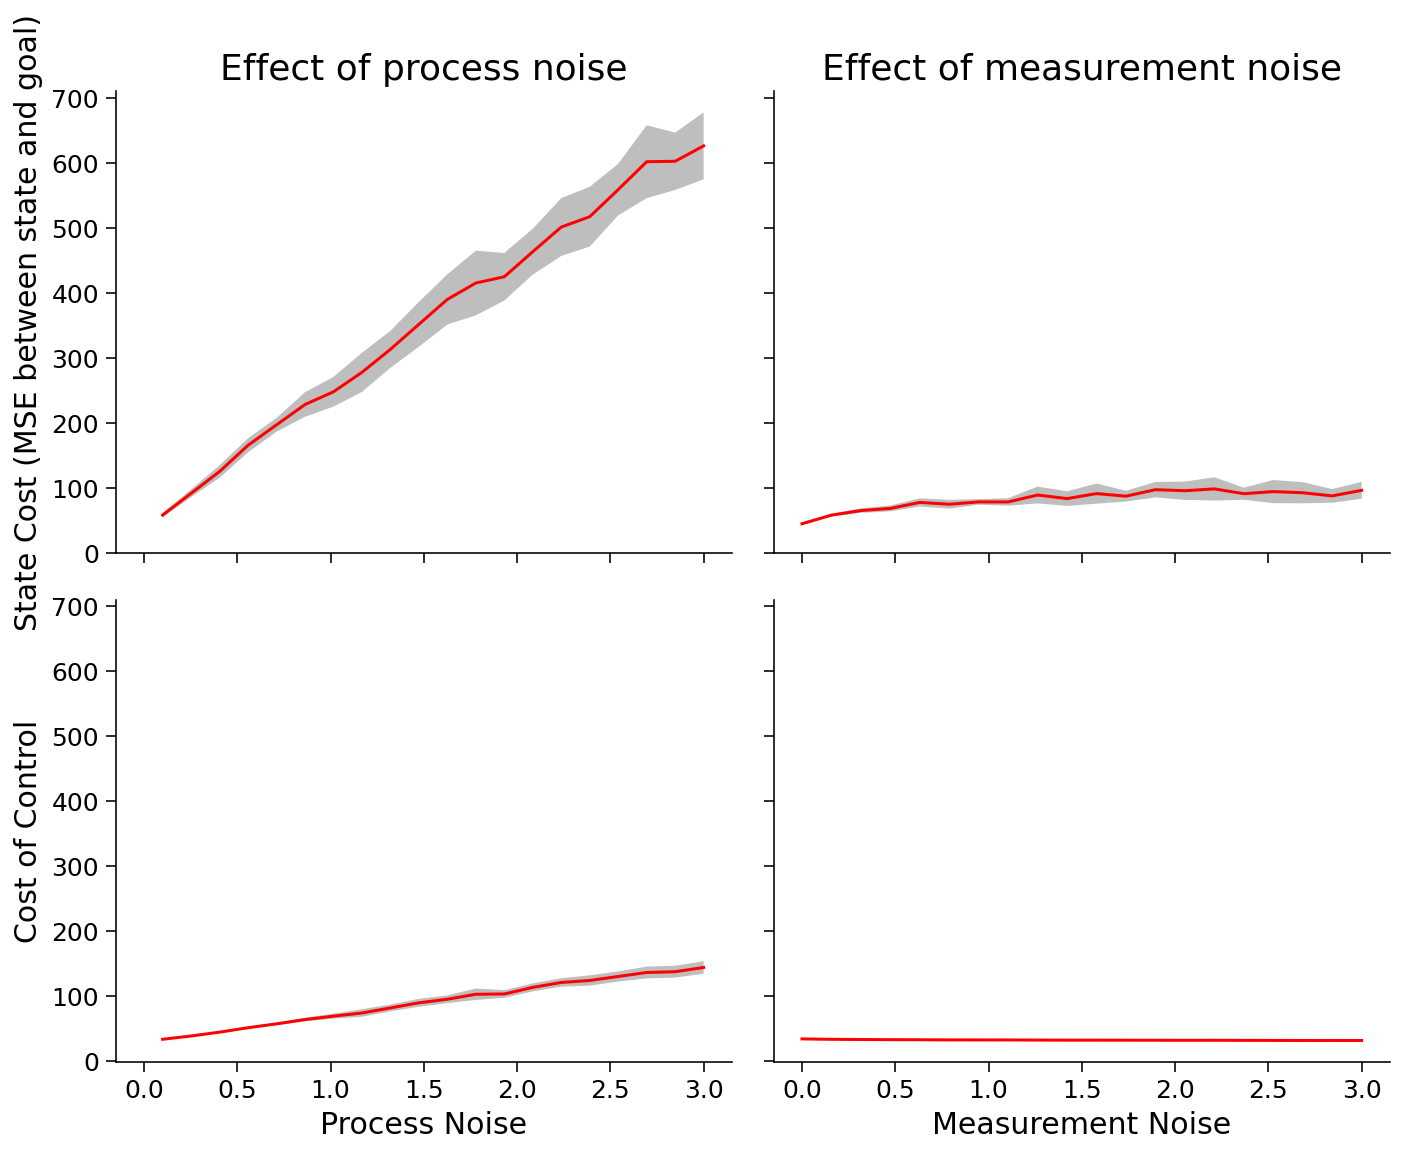

In [36]:
#@markdown Execute this cell to to quantify the dependence of state and control
#@markdown cost on process and measurement noise (takes ~20 seconds)

D = 0.9 # state parameter
B = 2   # control parameter
C = 1   # measurement parameter
noise_var = 0.1
T = 200  # time horizon
ini_state = 5      # initial state
process_noise_var = 0.1   # process noise
measurement_noise_var = 0.2     # measurement noise
rho = 1

# Format the above variables into a format acccepted by the Kalman Filter
n_dim_state = 1
n_dim_obs = 1
n_timesteps = T

transition_matrices = np.eye(n_dim_state) * D
transition_covariance = np.eye(n_dim_obs) * noise_var # process noise
observation_matrices = np.eye(n_dim_state) * C
observation_covariance = np.eye(n_dim_obs) * measurement_noise_var
initial_state_mean = np.ones(n_dim_state) * ini_state
initial_state_covariance = np.eye(n_dim_state) * .01
control_matrices = np.eye(n_dim_state) * B

# Implement LQG control over n_iter iterations, and record the MSE between state and goal
MSE_array_N_meas = []
MSE_array_N_proc = []
Jcontrol_array_N_meas = []
Jcontrol_array_N_proc = []
n_iter = 10
meas_noise_array = np.linspace(0,3,20)
proc_noise_array = np.linspace(0.1,3,20)

for i in range(n_iter):
  MSE_array = np.zeros(proc_noise_array.shape)
  Jcontrol_array = np.zeros(meas_noise_array.shape)
  for i in range(len(proc_noise_array)):

    transition_covariance = np.eye(n_dim_obs)  * proc_noise_array[i]
    observation_covariance = np.eye(n_dim_obs) * measurement_noise_var
    lqg = LQG(n_timesteps, n_dim_state, n_dim_obs,
          transition_matrices, transition_covariance, observation_matrices,
          observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)

    control_gain_lqg = lqg.control_gain_LQR_infinite(rho) * np.ones(n_timesteps)  # Get the control gain
    filtered_state_means_impl, filtered_state_covariances_impl, latent, measurement, control = lqg.filter_control(
        n_timesteps, control_gain_lqg)
    MSE_array[i] = lqg.calculate_J_state(latent)
    Jcontrol_array[i] = lqg.calculate_J_control(control)

  MSE_array_N_proc.append(MSE_array)
  Jcontrol_array_N_proc.append(Jcontrol_array)


  MSE_array = np.zeros(meas_noise_array.shape)
  Jcontrol_array = np.zeros(meas_noise_array.shape)
  for i in range(len(meas_noise_array)):

    observation_covariance = np.eye(n_dim_obs)  * meas_noise_array[i]
    transition_covariance = np.eye(n_dim_obs) * noise_var
    lqg = LQG(n_timesteps, n_dim_state, n_dim_obs,
          transition_matrices, transition_covariance, observation_matrices,
          observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)

    control_gain_lqg = lqg.control_gain_LQR_infinite(rho) * np.ones(n_timesteps)  # Get the control gain
    filtered_state_means_impl, filtered_state_covariances_impl, latent, measurement, control = lqg.filter_control(
        n_timesteps, control_gain_lqg)
    MSE_array[i] = lqg.calculate_J_state(latent)
    Jcontrol_array[i] = lqg.calculate_J_control(control)

  MSE_array_N_meas.append(MSE_array)
  Jcontrol_array_N_meas.append(Jcontrol_array)

MSE_array_proc_mean = np.mean(np.array(MSE_array_N_proc), axis = 0)
MSE_array_proc_std = np.std(np.array(MSE_array_N_proc), axis = 0)
MSE_array_meas_mean = np.mean(np.array(MSE_array_N_meas), axis = 0)
MSE_array_meas_std = np.std(np.array(MSE_array_N_meas), axis = 0)

Jcontrol_array_proc_mean = np.mean(np.array(Jcontrol_array_N_proc), axis = 0)
Jcontrol_array_proc_std = np.std(np.array(Jcontrol_array_N_proc), axis = 0)
Jcontrol_array_meas_mean = np.mean(np.array(Jcontrol_array_N_meas), axis = 0)
Jcontrol_array_meas_std = np.std(np.array(Jcontrol_array_N_meas), axis = 0)

# Visualize the quantification
f, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))

axs[0,0].plot(proc_noise_array, MSE_array_proc_mean, 'r-')
axs[0,0].fill_between(proc_noise_array, MSE_array_proc_mean+MSE_array_proc_std,
                MSE_array_proc_mean-MSE_array_proc_std, facecolor='tab:gray', alpha=0.5)
axs[0,0].set_title('Effect of process noise')
axs[0,0].set_ylabel('State Cost (MSE between state and goal)')

axs[0,1].plot(meas_noise_array, MSE_array_meas_mean, 'r-')
axs[0,1].fill_between(meas_noise_array, MSE_array_meas_mean+MSE_array_meas_std,
                MSE_array_meas_mean-MSE_array_meas_std, facecolor='tab:gray', alpha=0.5)
axs[0,1].set_title('Effect of measurement noise')

axs[1,0].plot(proc_noise_array, Jcontrol_array_proc_mean, 'r-')
axs[1,0].fill_between(proc_noise_array, Jcontrol_array_proc_mean+Jcontrol_array_proc_std,
                Jcontrol_array_proc_mean-Jcontrol_array_proc_std, facecolor='tab:gray', alpha=0.5)
axs[1,0].set_xlabel('Process Noise')
axs[1,0].set_ylabel('Cost of Control')

axs[1,1].plot(meas_noise_array, Jcontrol_array_meas_mean, 'r-')
axs[1,1].fill_between(meas_noise_array, Jcontrol_array_meas_mean+Jcontrol_array_meas_std,
                Jcontrol_array_meas_mean-Jcontrol_array_meas_std, facecolor='tab:gray', alpha=0.5)
axs[1,1].set_xlabel('Measurement Noise')
plt.show()

In [ ]:
#to_remove explanation
"""
While both sources of noise have an effect on the controlled state, the
process noise has a much larger effect. As the process noise w[t] increases,
state cost (MSE between state and goal) and  control cost increase drastically.
You can get an intuition as to why using the sliders in the demo above.  To make
matters worse, as the process noise gets larger, you will also need to put in
more effort to keep the system close to the goal.

The measurement noise v[t]  also has an effect on the accuracy of the
controlled state. As this noise increases, the MSE between the state and goal
increases. The cost of control in this case remains fairly constant with
increasing levels of measurement noise.
""";

---
# Summary

In this tutorial, you have extended the idea of optimal policy to the Astrocat example. You have learned about how to design an optimal controller with full observation of the state (linear quadratic regulator - LQR), and under partial observability of the state (linear quadratic gaussian - LQG).